## 比赛标题
Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 比赛描述

本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器使用 SVM 和决策树两种，对结果进行对比分析。


## 比赛介绍

### 案例背景

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

### 任务

本案例中需要完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求

* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求

* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响
* 尝试各种方法提升排行榜上预测性能




## 赛题说明
### 数据描述

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列`Id`，标识了每一个测试的样例。

### 文件说明

* train.csv：训练集
* test.csv：测试集，用户和商品保证在训练集中出现过，没有关于 votes 和 label 的列

文件使用 \t 分隔，可以使用 pandas 进行读取：

```python
import pandas as pd
train_df = pd.read_csv('train.csv', sep='\t')
```

### 提交格式

提交文件需要对测试集中每一条评论给出预测为高质量的**概率**，每行包括一个`Id`（和测试集对应）以及预测的概率`Predicted`（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
Id,Predicted
0,0.9
1,0.45
2,0.78
...
```

提交文件需要命名为`result.csv`

去掉停用词
ctr挖掘特征
fasttext
wordtovec
模型：集成学习、lgb，xgb


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
train_data=pd.read_csv('train.csv',sep='\t')
test_data=pd.read_csv('test.csv',sep='\t')

print(train_data.shape)
print(test_data.shape)

(57039, 7)
(57039, 1)


In [5]:
train_data['reviewText'][0]

"First off, allow me to correct a common mistake that was made by more than one reviewer here: This is most certainly not the first film ever made where animated characters interact with live actors. Pete's Dragon (1977), Mary Poppins (1964) and Song of the South (1946) all predate it, and if you want a lesson in cartoon history, so does Gertie the Dinosaur (1914). But that doesn't mean Who Framed Roger Rabbit is not a landmark film. It was revolutionary for its degree of interaction between the toons and the human characters, done so perfectly that they seem completely natural at first glance, but then amaze when you take a closer look - little things like Jessica Rabbit pinching Eddie Valiant's cheek, or Roger Rabbit hiding under the water in Valiant's sink, or beneath his coat, little details that took very creative special effects to be made convincing. It's also unique and original in the fact that some of it takes place in the real world, featuring animated characters, and some i

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57039 entries, 0 to 57038
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  57039 non-null  int64  
 1   asin        57039 non-null  int64  
 2   reviewText  57039 non-null  object 
 3   overall     57039 non-null  float64
 4   votes_up    57039 non-null  int64  
 5   votes_all   57039 non-null  int64  
 6   label       57039 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 3.0+ MB


In [ ]:
train_data.describe()

,reviewerID,asin,overall,votes_up,votes_all,label
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000


count    57039.000000
mean       255.126335
std        242.025413
min          1.000000
25%        100.000000
50%        187.000000
75%        325.000000
max       4322.000000
Name: text_len, dtype: float64


Text(0.5,1,'Histogram of char count')

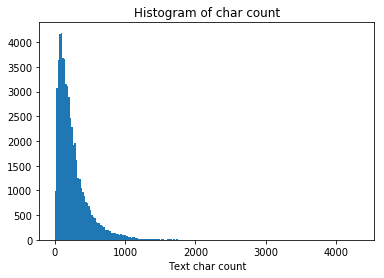

In [ ]:
##统计文本长度
train_data['text_len'] = train_data['reviewText'].apply(lambda x: len(x.split(' ')))
print(train_data['text_len'].describe())
_ = plt.hist(train_data['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")

Text(0.5,0,'category')

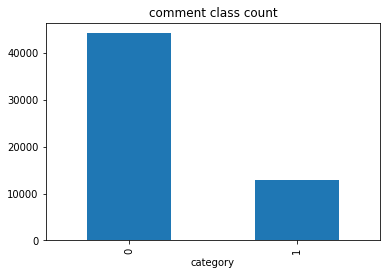

In [ ]:
##统计label种类
train_data['label'].value_counts().plot(kind='bar')
plt.title('comment class count')
plt.xlabel("category")

In [ ]:
##统计单词出现次数
from collections import Counter
all_lines = ' '.join(list(train_data['reviewText']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True)
print(len(word_count))
print(word_count[0])
print(word_count[-1])

654338
('the', 739355)
('Ghostbreakers"', 1)


In [ ]:
word_count[0:100]

[('the', 739355),
 ('and', 391103),
 ('of', 361795),
 ('a', 354147),
 ('to', 322494),
 ('is', 256211),
 ('', 250515),
 ('in', 206754),
 ('I', 164299),
 ('that', 157172),
 ('this', 140488),
 ('it', 122320),
 ('for', 108880),
 ('with', 106773),
 ('as', 104036),
 ('was', 102829),
 ('on', 85198),
 ('The', 84878),
 ('are', 77620),
 ('but', 77299),
 ('you', 68734),
 ('have', 67179),
 ('not', 66506),
 ('his', 64217),
 ('be', 61644),
 ('movie', 60203),
 ('film', 51392),
 ('by', 51001),
 ('one', 49246),
 ('from', 49159),
 ('an', 48203),
 ('at', 47918),
 ('he', 46768),
 ('all', 45116),
 ('who', 43505),
 ('they', 43260),
 ('like', 41186),
 ('has', 40776),
 ('or', 39186),
 ('about', 37970),
 ('so', 37790),
 ('just', 36667),
 ('her', 36303),
 ('more', 34608),
 ('out', 32400),
 ('some', 31981),
 ('This', 30052),
 ('would', 28890),
 ('their', 28851),
 ('what', 28793),
 ('very', 28716),
 ('will', 27770),
 ('when', 27280),
 ('my', 26741),
 ('if', 26402),
 ('up', 25998),
 ('than', 25700),
 ('It', 25334)

In [ ]:
stopwords={}.fromkeys([line.rstrip() for line in open('./stopwords.txt',encoding='utf-8')])
eng_stopwords=set(stopwords)
def clean_text(text):
    text=re.sub(r'[^a-zA-Z]',' ',text)
    words=text.lower().split()
    words=[w for w in words if w not in eng_stopwords]
    return ' '.join(words)

In [ ]:
# TF-IDF 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
train_df = pd.read_csv('ctrain.csv')
test_data=pd.read_csv('ctest.csv')
train_df=train_df.dropna()
result=test_data['Id']
train_text = train_df['reviewText']
test_text = test_data['reviewText']
all_text = pd.concat([train_text, test_text])
tfidf = TfidfVectorizer(ngram_range=(1,10), max_features=1000000)
tfidf.fit(train_text) 
train_test = tfidf.transform(train_df['reviewText'])
test_data=tfidf.transform(test_data['reviewText'])
#clf=RandomForestClassifier()
clf = LogisticRegression()
clf.fit(train_test.toarray(), train_df['label'].values)
val_pred = clf.predict(test_data)
prob=clf.predict_proba(test_data)[:,1]
prob=pd.DataFrame(prob,columns=['Predicted'])
res = pd.concat([result,prob],axis=1)
res.to_csv('result.csv')

In [ ]:
train_df = pd.read_csv('ctrain.csv')

In [ ]:
train_df=train_df[['reviewText','label']]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
train=pd.read_csv('ctrain.csv')
test=pd.read_csv('ctest.csv')
from sklearn.model_selection import train_test_split
train=train.dropna()
x_train,x_test,y_train,y_test=train_test_split(train['reviewText'],train['label'],test_size=0.2)
from sklearn.feature_extraction.text import TfidfVectorizer
train_text = train['reviewText']
test_text = test['reviewText']
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
tfidf.fit(train_text) 
x_train = tfidf.transform(x_train)
x_test=tfidf.transform(x_test)
# -*-coding:utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
class AdaBoost:
    # 基分类器默认为多分类的逻辑回归
    def __init__(self,m,\
        clf=LogisticRegression()):
        # 基分类器数量
        self.m = m
        # 基分类器模型
        self.clf = clf
        # 缓存基分类器和权重参数
        self.clf_arr = []
        self.alpha_arr = []

    # 指定训练数据集、基分类器、迭代次数
    def fit(self,X,Y):
        num = X.shape[0]
        # 初始化样本权重
        W = np.ones(num) / num
 
        # 迭代
        for i in range(self.m):
            # 基分类器预测
            self.clf.fit(X, Y, sample_weight=W)
            self.clf_arr.extend([self.clf])
            Y_pred = self.clf.predict(X)
 
            # 分类误差率
            indic_arr = [1 if Y_pred[j] != Y[j] else 0 for j in range(num)]
            err = np.dot(W, np.array(indic_arr))
            print("classify error rate is ",err)

            if err>0.5:
              self.m=i-1
              return 
            # 分类器系数
            alpha = err/(1-err)
            self.alpha_arr.extend([1-alpha])
 
            # 更新权重
            temp = W * (alpha**[1-i for i in indic_arr])
            W = temp / np.sum(temp)
        return self
    def predict(self, X,Y):
        num = X.shape[0]
        mulit_idx_pred = []
        mulit_Y_pred = []
        for i in range(self.m):
            Y_pred = self.clf_arr[i].predict(X)
            mulit_Y_pred.append(Y_pred.tolist())
            indic_arr = [1 if Y_pred[i] == Y[i] else 0 for i in range(num)]
            temp = [np.log(self.alpha_arr[i])*k for k in indic_arr]
            mulit_idx_pred.append(temp)
        # 保存各个基分类器预测的最大索引
        max_idx_pred = np.array(mulit_idx_pred).argmax(axis=0)
        # 保存各个基分类器的预测值
        mulit_Y_pred = np.array(mulit_Y_pred).T
        # 获取最大索引对应的预测标签
        result = np.array([x[max_idx_pred[i]] for i,x in enumerate(mulit_Y_pred)],dtype=np.float64)
        return result
    def score(self,X,Y):
        Y_pred = self.predict(X,Y)
        count = 0.
        for i in range(len(Y)):
            if Y_pred[i]==Y[i]:
                count +=1
        return count/np.float(len(Y))
if __name__=="__main__":
    clf = LogisticRegression()
    num = x_train.shape[0]
    # 初始化样本权重
    y_train=list(y_train)
    y_test=list(y_test)
    W = np.ones(num) / num
    clf.fit(x_train,y_train,sample_weight=W)
    print("train accuracy is ",clf.score(x_train,y_train))
    print("test accuracy is ",clf.score(x_test,y_test))
    adaboost = AdaBoost(2)
    adaboost.fit(x_train,y_train)
    print("train accuracy is ",adaboost.score(x_train,y_train))
    print("test accuracy is ",adaboost.score(x_test,y_test))

train accuracy is  0.7753670830593907
test accuracy is  0.767531556802244
classify error rate is  0.22463291694060922
classify error rate is  0.32384269740379706
train accuracy is  0.6884944115713346
test accuracy is  0.6846949509116409


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
train=pd.read_csv('ctrain.csv')
test=pd.read_csv('ctest.csv')
from sklearn.model_selection import train_test_split
train=train.dropna()
x_train,x_test,y_train,y_test=train_test_split(train['reviewText'],train['label'],test_size=0.2)
from sklearn.feature_extraction.text import TfidfVectorizer
train_text = train['reviewText']
test_text = test['reviewText']
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
tfidf.fit(train_text) 
x_train = tfidf.transform(x_train)
x_test=tfidf.transform(x_test)
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(base_estimator=KNeighborsClassifier(),
                       n_estimators=10, random_state=0)
#model = AdaBoostClassifier(GaussianNB(),n_estimators=200, learning_rate=0.8)
model.fit(x_train, y_train)
model.score(x_train,y_train)

ValueError: KNeighborsClassifier doesn't support sample_weight.

In [9]:
!pip install pytest

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 286kB 16.8MB/s eta 0:00:01
     |████████████████████████████████| 102kB 32.6MB/s ta 0:00:01


In [10]:
import inspect 
from sklearn.utils.testing import all_estimators 
for name, clf in all_estimators(type_filter='classifier'): 
    if 'sample_weight' in inspect.getargspec(clf.fit)[0]: 
        print(name) 

AdaBoostClassifier
BaggingClassifier
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianNB
GradientBoostingClassifier
LinearSVC
LogisticRegression
LogisticRegressionCV
MultiOutputClassifier
MultinomialNB
NuSVC
Perceptron
RandomForestClassifier
RidgeClassifier
RidgeClassifierCV
SGDClassifier
SVC
StackingClassifier
VotingClassifier


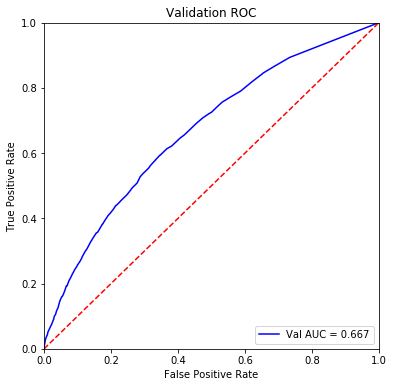

In [6]:
from sklearn import metrics
import pylab as plt
import warnings;
warnings.filterwarnings('ignore')
pred = model.predict_proba(x_test)[:,1]
#############画图部分
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
train=pd.read_csv('ctrain.csv')
test=pd.read_csv('ctest.csv')
from sklearn.model_selection import train_test_split
train=train.dropna()
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
train_text = train['reviewText']
#test_text = test['reviewText']
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
tfidf.fit(train_text) 
m=list()
term=list()
result=list()
class Bagging:
    def __init__(self,n_estimators,estimator,number):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.number=number
        self.test_data=list()

    def RepetitionRandomSampling(self,data,number):
        print(len(data))   
        data = np.array(data)
        sample=[]
        for i in range(int(self.number)):
             sample.append(data[random.randint(0,len(data)-1)])
        return sample
    def fits(self,data):
        x_train,x_test,y_train,y_test=train_test_split(data['reviewText'],data['label'],test_size=0.2)
        test = tfidf.transform(x_test)
        test.toarray()
        self.test_data=np.array(y_test)
        print("y_test[0]:")
        print(self.test_data[0])
        print(self.test_data)
        for i in range (self.n_estimators):
            train_data=data.sample(frac=0.1,replace=True,axis=0) 
            #train_data=self.RepetitionRandomSampling(data,self.number)
            train= tfidf.transform(train_data['reviewText']) 
            train.toarray()
            clf=self.estimator
            clf.fit(train,train_data['label'])
            m.append(clf.predict(test))
        return m
    def Score(self):
        global result
        term = np.transpose(m)
        #print(len(term))
        for i in range (len(term)):
            if(term[i].mean()>=0.5):
                result.append(1)
            if(term[i].mean()<0.5):
                result.append(0)
        result=np.array(result)
        count=0
        for i in range(len(term)):
            if self.test_data[i]==result[i]:
                count +=1 
        print(count/np.float(len(term)))
        return count/np.float(len(term))
if __name__=="__main__":
    bagging=Bagging(3,DecisionTreeClassifier(),1000)
    bagging.fits(train)
    bagging.Score()
